In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import re
import math
import seaborn as sns
import pandas as pd
import random
import statistics
import gzip
import scipy
from collections import Counter
import neutcurve

In [8]:
b2AR_df = pd.read_csv('b2AR_all_data_annot.csv.gz', compression = 'gzip', index_col=0, low_memory=False)


b2AR_df_filt = b2AR_df.loc[(b2AR_df['surfexp_min_cells'] >50) & \
                            (b2AR_df['Nb80_isoP1_norm_Gal4_reads'] > 2e-05)].copy()
b2AR_df_filt_missense = b2AR_df_filt.loc[(b2AR_df_filt['stop'] == False) & \
(b2AR_df_filt['syn_WT'] == False) & \
(b2AR_df_filt['del'] == False)].copy()

print (len(b2AR_df_filt))

7851


In [9]:
b2AR_df_filt_QC = b2AR_df.loc[(b2AR_df['surfexp_min_cells'] >50) & \
                            (b2AR_df['Nb80_10uM_norm_Gal4_norm_reads'] > 2e-05) & \
                            (b2AR_df['r2'] > 0.9) & \
                            (b2AR_df['Emax_QC'] == True) & \
                            (b2AR_df['slope'] < 2)].copy()

b2AR_df_filt_missense_QC = b2AR_df_filt_QC.loc[(b2AR_df_filt_QC['stop'] == False) & \
(b2AR_df_filt_QC['syn_WT'] == False) & \
(b2AR_df_filt_QC['del'] == False)].copy()

In [10]:
print (len(b2AR_df_filt_QC))
print (len(b2AR_df_filt_missense_QC))

5588
5094


In [11]:
import statsmodels.api as sm # to build a LOWESS model
import statsmodels.nonparametric.smoothers_lowess
lowess = sm.nonparametric.lowess

In [12]:
x = b2AR_df_filt_missense['surfexp_reps_comb']
y = b2AR_df_filt_missense['Nb80_isoP_reps_comb']
Nb80_isoP_lowess = lowess(y, x, frac=0.5, it=3, delta=0.0, xvals=x, is_sorted=False, missing='drop', return_sorted=True)

b2AR_df_filt_missense['Nb80_isoP_lowess'] = Nb80_isoP_lowess
b2AR_df_filt_missense['Nb80_isoP_residual'] = b2AR_df_filt_missense['Nb80_isoP_reps_comb'] - b2AR_df_filt_missense['Nb80_isoP_lowess']
b2AR_df_filt_missense['Nb80_isoP_zscore'] = b2AR_df_filt_missense['Nb80_isoP_residual'] / b2AR_df_filt_missense['Nb80_isoP_reps_comb_SEM']


In [13]:
x = b2AR_df_filt_missense['surfexp_reps_comb']
y = b2AR_df_filt_missense['BArr_isoP_reps_comb']
Nb80_isoP_lowess = lowess(y, x, frac=0.5, it=3, delta=0.0, xvals=x, is_sorted=False, missing='drop', return_sorted=True)

b2AR_df_filt_missense['BArr_isoP_lowess'] = Nb80_isoP_lowess
b2AR_df_filt_missense['BArr_isoP_residual'] = b2AR_df_filt_missense['BArr_isoP_reps_comb'] - b2AR_df_filt_missense['BArr_isoP_lowess']
b2AR_df_filt_missense['BArr_isoP_zscore'] = b2AR_df_filt_missense['BArr_isoP_residual'] / b2AR_df_filt_missense['BArr_isoP_reps_comb_SEM']


In [14]:
x = b2AR_df_filt_missense['Nb80_isoP_reps_comb']
y = b2AR_df_filt_missense['BArr_isoP_reps_comb']
Nb80_BArr_isoP_lowess = lowess(y, x, frac=0.5, it=3, delta=0.0, xvals=x, is_sorted=False, missing='drop', return_sorted=True)
b2AR_df_filt_missense['Nb80_BArr_isoP_lowess'] = Nb80_BArr_isoP_lowess

b2AR_df_filt_missense['Nb80_BArr_isoP_residual'] = b2AR_df_filt_missense['BArr_isoP_reps_comb'] - b2AR_df_filt_missense['Nb80_BArr_isoP_lowess']
b2AR_df_filt_missense['Nb80_BArr_isoP_zscore'] = b2AR_df_filt_missense['Nb80_BArr_isoP_residual'] / \
((b2AR_df_filt_missense['Nb80_isoP_reps_comb_SEM'] + b2AR_df_filt_missense['BArr_isoP_reps_comb_SEM']) / 2)


In [15]:
x = b2AR_df_filt_missense_QC['surfexp_reps_comb']
y = b2AR_df_filt_missense_QC['EC50_log']

surfexp_EC50_lowess = lowess(y, x, frac=0.5, it=3, delta=0.0, xvals=x, is_sorted=False, missing='drop', return_sorted=True)
b2AR_df_filt_missense_QC['surfexp_EC50_lowess'] = surfexp_EC50_lowess
b2AR_df_filt_missense_QC['surfexp_EC50_residual'] = b2AR_df_filt_missense_QC['EC50_log'] - b2AR_df_filt_missense_QC['surfexp_EC50_lowess']


In [67]:
NAM_residues = [122, 125, 129, 206, 210, 211,214]
PAM_residues = [126, 130, 133, 137, 144, 145,149, 152, 153]
pocket_4_residues = [215, 216, 219, 220, 223, 276, 279, 280, 283, 284]
pocket_5_residues = sorted([224, 226, 227, 230, 263, 264, 269, 220, 223])

In [17]:
max_sig_resid_dict = b2AR_df_filt_missense['Nb80_isoP_residual'].to_dict()
EC50_resid_dict = b2AR_df_filt_missense_QC['surfexp_EC50_residual'].to_dict()
Nb80_BArr_resid_dict = b2AR_df_filt_missense['Nb80_BArr_isoP_residual'].to_dict()

In [18]:
aas = ['A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'S', 'T', 'N', 'Q', 'C', 'G', 'P', 'R', 'H', 'K', 'D', 'E']

b2AR_aa_seq = 'MGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGIVMSLIVLAIVFGNVLVITAIAKFERLQTVTNYFITSLACADLVMGLAVVPFGAAHILMKMWTFGNFWCEFWTSIDVLCVTASIETLCVIAVDRYFAITSPFKYQSLLTKNKARVIILMVWIVSGLTSFLPIQMHWYRATHQEAINCYANETCCDFFTNQAYAIASSIVSFYVPLVIMVFVYSRVFQEAKRQLQKIDKSEGRFHVQNLSQVEQDGRTGHGLRRSSKFCLKEHKALKTLGIIMGTFTLCWLPFFIVNIVHVIQDNLIRKEVYILLNWIGYVNSGFNPLIYCRSPDFRIAFQELLCLRRSSLKAYGNGYSSNGNTGEQSGYHVEQEKENKLLCEDLPGTEDFVGHQGTVPSDNIDSQGRNCSTNDSLL'
poss = list(range(1, (len(b2AR_aa_seq)+1)))
ordered_vars = []
for pos in poss:
    for aa in aas:
        ordered_vars.append(b2AR_aa_seq[pos-1]+str(pos)+ aa)

In [19]:
ordered_vals = []
for var in ordered_vars:
    if var in max_sig_resid_dict:
        ordered_vals.append(max_sig_resid_dict[var])
    else:
        ordered_vals.append(np.nan)

import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["purple","white","green"])

b2AR_maxsig_re = np.reshape(ordered_vals, (len(b2AR_aa_seq), 20))
b2AR_maxsig_heatmap = pd.DataFrame(b2AR_maxsig_re, columns=aas, index=np.arange(1, len(b2AR_aa_seq)+1)).T
b2AR_maxsig_heatmap.loc['Median'] = b2AR_maxsig_heatmap[:20].median(axis=0)
#b2AR_maxsig_heatmap.loc['Average'] = b2AR_maxsig_heatmap[:20].mean(axis=0)


In [20]:
overlap_CoF_hits = [47, 120, 122, 215, 306, 311, 321, 332]
overlap_GoF_hits = [87, 101, 124, 130, 170, 187, 189, 218, 231, 251, 268, 283, 313, 345, 355, 359, 362, 375, 392, 410]
overlap_LoF_hits = [76, 78, 79, 82, 88, 106, 113, 114, 117, 118, 119, 121, 127, 128, 129, 131, 135, 136, 138, 139, 141, 165, 190, 191, 193, 199, 203, 204, 207, 208, 209, 219, 286, 289, 290, 293, 294, 312, 315, 318, 322, 325, 326, 327, 328, 329, 330]


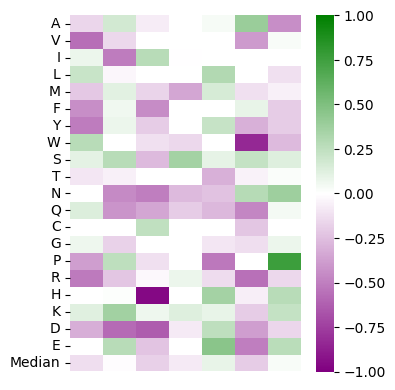

In [21]:
plt.figure(figsize=(4, 4))

sns.heatmap(b2AR_maxsig_heatmap[NAM_residues], cmap=cmap, center=0, vmin=-1, vmax=1)
plt.xticks([])
plt.yticks()

plt.tight_layout()
#plt.savefig('NAM_Nb80_resid_wide.png', dpi=250)

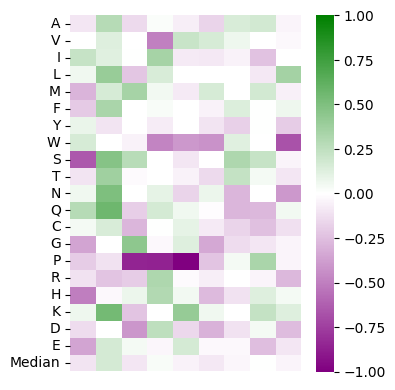

In [22]:
plt.figure(figsize=(4, 4))

sns.heatmap(b2AR_maxsig_heatmap[PAM_residues], cmap=cmap, center=0, vmin=-1, vmax=1)
plt.xticks([])
plt.yticks()

plt.tight_layout()
#plt.savefig('PAM_Nb80_resid_wide.png', dpi=250)

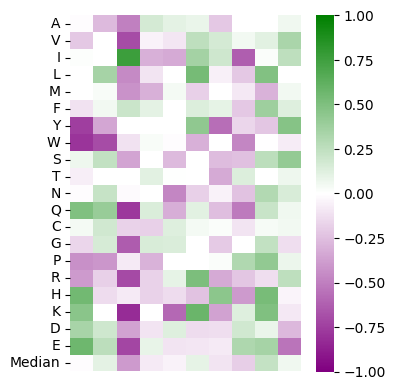

In [23]:
plt.figure(figsize=(4, 4))

sns.heatmap(b2AR_maxsig_heatmap[pocket_4_residues], cmap=cmap, center=0, vmin=-1, vmax=1)
plt.xticks([])
plt.yticks()

plt.tight_layout()
#plt.savefig('pocket4_Nb80_resid_wide.png', dpi=250)

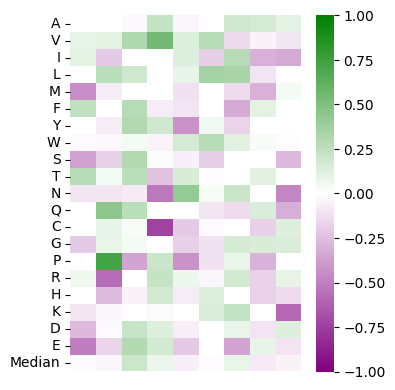

In [24]:
plt.figure(figsize=(4, 4))

sns.heatmap(b2AR_maxsig_heatmap[pocket_5_residues], cmap=cmap, center=0, vmin=-1, vmax=1)
plt.xticks([])
plt.yticks()

plt.tight_layout()
#plt.savefig('pocket5_Nb80_resid_wide.png', dpi=250)

In [25]:
sig_dict = {}
for pos in range(1, len(b2AR_aa_seq)):
    if pos in overlap_LoF_hits:
        sig_dict[pos] = 1
    elif pos in overlap_GoF_hits:
        sig_dict[pos] = 2
    elif pos in overlap_CoF_hits:
        sig_dict[pos] = 3
    else:
        sig_dict[pos] = 0



In [26]:
[sig_dict[i] for i in NAM_residues]

[3, 0, 1, 0, 0, 0, 0]

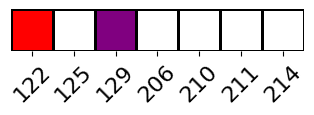

In [27]:
plt.figure(figsize=(3.3, 1.2))
sig_df = pd.DataFrame.from_dict(sig_dict, orient='index')
cmap = ['white','purple', 'red']#'green','red']
sns.heatmap(sig_df.loc[NAM_residues].T, cmap=cmap, square=True, linewidths=1, linecolor='k', cbar=False)
plt.xticks(rotation=45, fontsize=16)
plt.yticks([])

plt.tight_layout()
#plt.savefig('NAM_signaling_emax_cats.png', dpi=250)

In [28]:
[sig_dict[i] for i in PAM_residues]

[0, 2, 0, 0, 0, 0, 0, 0, 0]

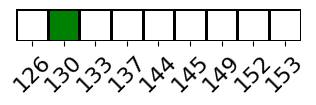

In [29]:
sig_df = pd.DataFrame.from_dict(sig_dict, orient='index')
cmap = ['white','purple','green']

plt.figure(figsize=(3.3, 1.2))
sns.heatmap(sig_df.loc[PAM_residues].T, cmap=cmap, square=True, linewidths=1, linecolor='k', cbar=False)
plt.xticks(rotation=45, fontsize=16)
plt.yticks([])

plt.tight_layout()

In [30]:
[sig_dict[i] for i in pocket_4_residues]

[3, 0, 1, 0, 0, 0, 0, 0, 2, 0]

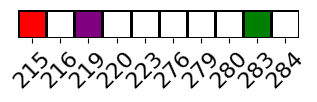

In [68]:
sig_df = pd.DataFrame.from_dict(sig_dict, orient='index')
cmap = ['white','purple','green','red']

plt.figure(figsize=(3.3, 1.2))
sns.heatmap(sig_df.loc[pocket_4_residues].T, cmap=cmap, square=True, linewidths=1, linecolor='k', cbar=False)
plt.xticks(rotation=45, fontsize=16)
plt.yticks([])

plt.tight_layout()
#plt.savefig('p4_signaling_emax_cats.png', dpi=250)

In [69]:
[sig_dict[i] for i in pocket_5_residues]

[0, 0, 0, 0, 0, 0, 0, 0, 0]

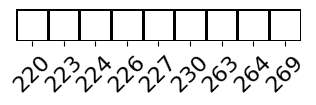

In [70]:
sig_df = pd.DataFrame.from_dict(sig_dict, orient='index')
cmap = ['white','purple','green','red']

plt.figure(figsize=(3.3, 1.2))
sns.heatmap(sig_df.loc[pocket_5_residues].T, cmap=cmap, square=True, linewidths=1, linecolor='k', cbar=False)
plt.xticks(rotation=45, fontsize=16)
plt.yticks([])

plt.tight_layout()
#plt.savefig('p4_signaling_emax_cats.png', dpi=250)

In [71]:
BArr_biased = [138, 139, 255, 326, 373, 406]
Nb80_biased = [51, 71, 83, 86, 99, 101, 102, 168, 173, 181, 184, 185, 196, 209, 211, 285, 306, 323, 330]
bias_switches = [332, 308, 199, 411, 328, 189, 46, 356,  40, 279, 111, 318,  63, 166, 327,  84, 313, 298, 387, 176]


In [72]:
ordered_vals = []
for var in ordered_vars:
    if var in Nb80_BArr_resid_dict:
        ordered_vals.append(Nb80_BArr_resid_dict[var])
    else:
        ordered_vals.append(np.nan)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["orange","white","blue"])

b2AR_bias_re = np.reshape(ordered_vals, (len(b2AR_aa_seq), 20))
b2AR_bias_heatmap = pd.DataFrame(b2AR_bias_re, columns=aas, index=np.arange(1, len(b2AR_aa_seq)+1)).T
b2AR_bias_heatmap.loc['Median'] = b2AR_bias_heatmap[:20].median(axis=0)


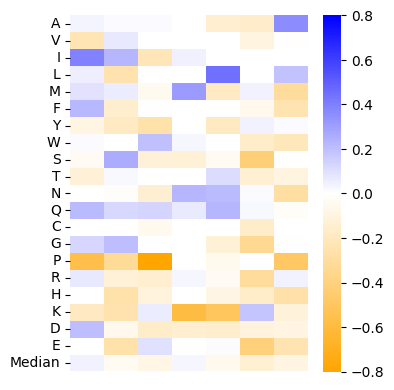

In [73]:
plt.figure(figsize=(4, 4))

sns.heatmap(b2AR_bias_heatmap[NAM_residues], cmap=cmap, center=0, vmin=-0.8, vmax=0.8)
plt.xticks([])
plt.yticks()

plt.tight_layout()
#plt.savefig('NAM_bias_resid_wide.png', dpi=250)

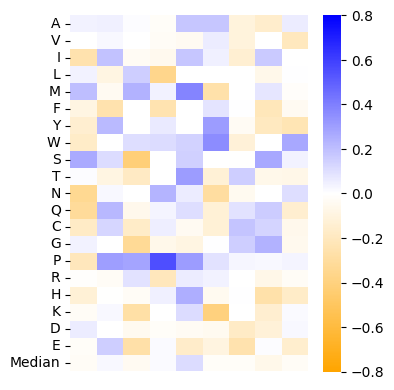

In [74]:
plt.figure(figsize=(4, 4))

sns.heatmap(b2AR_bias_heatmap[PAM_residues], cmap=cmap, center=0, vmin=-0.8, vmax=0.8)
plt.xticks([])
plt.tight_layout()
#plt.savefig('PAM_bias_resid_wide.png', dpi=250)

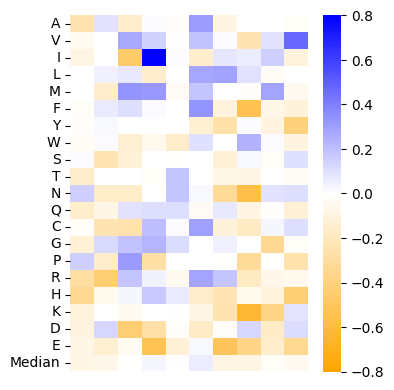

In [75]:
plt.figure(figsize=(4, 4))

sns.heatmap(b2AR_bias_heatmap[pocket_4_residues], cmap=cmap, center=0, vmin=-0.8, vmax=0.8)
plt.xticks([])
plt.tight_layout()
#plt.savefig('pocket4_bias_resid_wide.png', dpi=250)

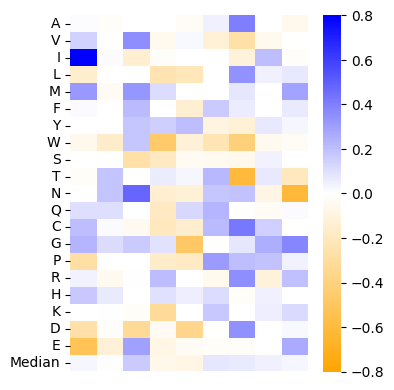

In [76]:
plt.figure(figsize=(4, 4))

sns.heatmap(b2AR_bias_heatmap[pocket_5_residues], cmap=cmap, center=0, vmin=-0.8, vmax=0.8)
plt.xticks([])
plt.tight_layout()
#plt.savefig('pocket5_bias_resid_wide.png', dpi=250)

In [77]:
bias_dict = {}
for pos in range(1, len(b2AR_aa_seq)):
    if pos in Nb80_biased:
        bias_dict[pos] = 1
    elif pos in BArr_biased:
        bias_dict[pos] = 2
    elif pos in bias_switches:
        bias_dict[pos] = 3
    else:
        bias_dict[pos] = 0

In [78]:
[bias_dict[i] for i in NAM_residues]

[0, 0, 0, 0, 0, 1, 0]

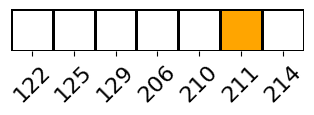

In [79]:
plt.figure(figsize=(3.3, 1.2))
bias_df = pd.DataFrame.from_dict(bias_dict, orient='index')
cmap = ['white', 'orange']#,'royalblue','magenta',]
sns.heatmap(bias_df.loc[NAM_residues].T, cmap=cmap, square=True, linewidths=1, linecolor='k', cbar=False)
plt.xticks(rotation=45, fontsize=16)
plt.yticks([])

plt.tight_layout()
#plt.savefig('NAM_signaling_bias_cats.png', dpi=250)

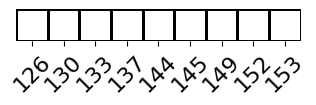

In [80]:
plt.figure(figsize=(3.3, 1.2))
bias_df = pd.DataFrame.from_dict(bias_dict, orient='index')
cmap = ['white', 'orange']#,'royalblue','magenta',]
sns.heatmap(bias_df.loc[PAM_residues].T, cmap=cmap, square=True, linewidths=1, linecolor='k', cbar=False)
plt.xticks(rotation=45, fontsize=16)
plt.yticks([])

plt.tight_layout()
#plt.savefig('NAM_signaling_bias_cats.png', dpi=250)

In [81]:
[bias_dict[i] for i in pocket_4_residues]

[0, 0, 0, 0, 0, 0, 3, 0, 0, 0]

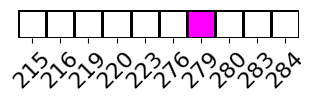

In [82]:
plt.figure(figsize=(3.3, 1.2))
bias_df = pd.DataFrame.from_dict(bias_dict, orient='index')
cmap = ['white', 'orange','royalblue','magenta',]
sns.heatmap(bias_df.loc[pocket_4_residues].T, cmap=cmap, square=True, linewidths=1, linecolor='k', cbar=False)
plt.xticks(rotation=45, fontsize=16)
plt.yticks([])

plt.tight_layout()
#plt.savefig('NAM_signaling_bias_cats.png', dpi=250)

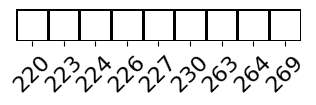

In [83]:
plt.figure(figsize=(3.3, 1.2))
bias_df = pd.DataFrame.from_dict(bias_dict, orient='index')
cmap = ['white', 'orange','royalblue','magenta',]
sns.heatmap(bias_df.loc[pocket_5_residues].T, cmap=cmap, square=True, linewidths=1, linecolor='k', cbar=False)
plt.xticks(rotation=45, fontsize=16)
plt.yticks([])

plt.tight_layout()
#plt.savefig('NAM_signaling_bias_cats.png', dpi=250)

In [84]:
EC50_LoF = [71,  72,  78,  90, 104, 107, 108, 109, 111, 114, 118, 129, 135, 138,
       141, 146, 147, 160, 164, 171, 173, 175, 176, 192, 193, 200, 208, 209,
       214, 215, 221, 280, 281, 290, 292, 293, 294, 303, 306, 308, 318, 321,
       323, 328, 330, 339]

EC50_GoF = [6,  14,  15,  44,  50,  58,  73,  74,  92, 124, 130, 225, 230, 233,
       237, 251, 252, 262, 268, 272, 274, 313, 331, 333, 357, 363, 380, 386]

EC50_CoF = [17,  37,  68,  87, 115, 120, 122, 123, 125, 132, 133, 136, 149, 166,
       167, 195, 202, 212, 218, 226, 275, 276, 279, 282, 314, 324]

In [85]:
ordered_vals = []
for var in ordered_vars:
    if var in EC50_resid_dict:
        ordered_vals.append(EC50_resid_dict[var])
    else:
        ordered_vals.append(np.nan)

import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["saddlebrown","white","mediumaquamarine"])

b2AR_EC50_re = np.reshape(ordered_vals, (len(b2AR_aa_seq), 20))
b2AR_EC50_heatmap = pd.DataFrame(b2AR_EC50_re, columns=aas, index=np.arange(1, len(b2AR_aa_seq)+1)).T
b2AR_EC50_heatmap.loc['Median'] = b2AR_EC50_heatmap[:20].median(axis=0)


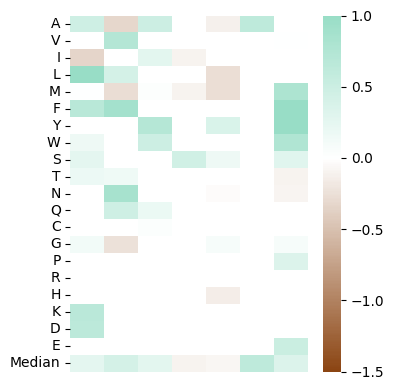

In [86]:
plt.figure(figsize=(4, 4))

sns.heatmap(b2AR_EC50_heatmap[NAM_residues], cmap=cmap, center=0, vmin=-1.5, vmax=1)
plt.xticks([])
plt.tight_layout()
#plt.savefig('NAM_EC50_resid_wide.png', dpi=250)

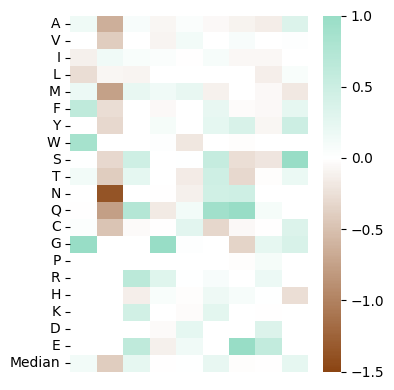

In [87]:
plt.figure(figsize=(4, 4))

sns.heatmap(b2AR_EC50_heatmap[PAM_residues], cmap=cmap, center=0, vmin=-1.5, vmax=1)
plt.xticks([])
plt.tight_layout()
#plt.savefig('PAM_EC50_resid_wide.png', dpi=250)

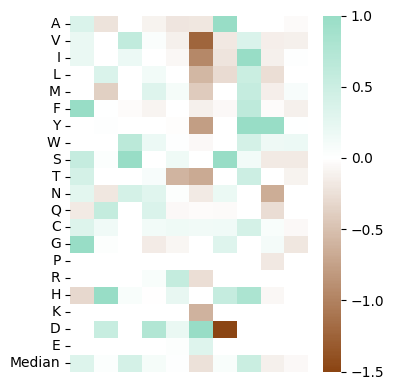

In [88]:
plt.figure(figsize=(4, 4))

sns.heatmap(b2AR_EC50_heatmap[pocket_4_residues], cmap=cmap, center=0, vmin=-1.5, vmax=1)
plt.xticks([])
plt.tight_layout()
#plt.savefig('pocket_4_EC50_resid_wide.png', dpi=250)

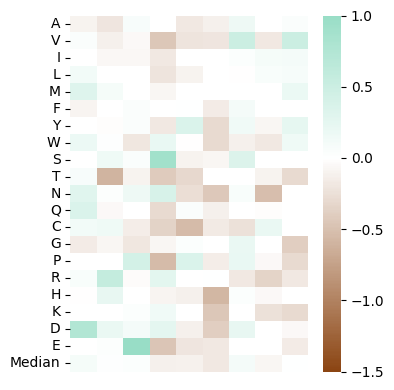

In [89]:
plt.figure(figsize=(4, 4))

sns.heatmap(b2AR_EC50_heatmap[pocket_5_residues], cmap=cmap, center=0, vmin=-1.5, vmax=1)
plt.xticks([])
plt.tight_layout()
#plt.savefig('pocket_5_EC50_resid_wide.png', dpi=250)

In [90]:
EC50_dict = {}
for pos in range(1, len(b2AR_aa_seq)):
    if pos in EC50_LoF:
        EC50_dict[pos] = 1
    elif pos in EC50_GoF:
        EC50_dict[pos] = 2
    elif pos in EC50_CoF:
        EC50_dict[pos] = 3
    else:
        EC50_dict[pos] = 0


In [91]:
[EC50_dict[i] for i in NAM_residues]

[3, 3, 1, 0, 0, 0, 1]

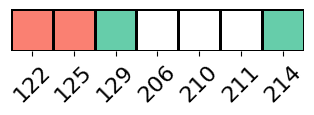

In [92]:
plt.figure(figsize=(3.3, 1.2))
EC50_df = pd.DataFrame.from_dict(EC50_dict, orient='index')
cmap = ['white','mediumaquamarine','saddlebrown','salmon']
sns.heatmap(EC50_df.loc[NAM_residues].T, cmap=cmap, square=True, linewidths=1, linecolor='k', cbar=False)
plt.xticks(rotation=45, fontsize=16)
plt.yticks([])

plt.tight_layout()
#plt.savefig('NAM_signaling_EC50_cats.png', dpi=250)

In [93]:
[EC50_dict[i] for i in PAM_residues]

[0, 2, 3, 0, 0, 0, 3, 0, 0]

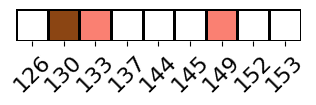

In [94]:
plt.figure(figsize=(3.3, 1.2))
EC50_df = pd.DataFrame.from_dict(EC50_dict, orient='index')
cmap = ['white','mediumaquamarine','saddlebrown','salmon']
sns.heatmap(EC50_df.loc[PAM_residues].T, cmap=cmap, square=True, linewidths=1, linecolor='k', cbar=False)
plt.xticks(rotation=45, fontsize=16)
plt.yticks([])

plt.tight_layout()
#plt.savefig('NAM_signaling_EC50_cats.png', dpi=250)

In [95]:
[EC50_dict[i] for i in pocket_4_residues]

[1, 0, 0, 0, 0, 3, 3, 1, 0, 0]

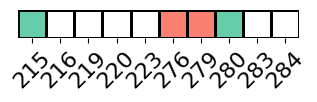

In [96]:
plt.figure(figsize=(3.3, 1.2))
EC50_df = pd.DataFrame.from_dict(EC50_dict, orient='index')
cmap = ['white','mediumaquamarine','saddlebrown','salmon']
sns.heatmap(EC50_df.loc[pocket_4_residues].T, cmap=cmap, square=True, linewidths=1, linecolor='k', cbar=False)
plt.xticks(rotation=45, fontsize=16)
plt.yticks([])

plt.tight_layout()
#plt.savefig('NAM_signaling_EC50_cats.png', dpi=250)

In [97]:
[EC50_dict[i] for i in pocket_5_residues]

[0, 0, 0, 3, 0, 2, 0, 0, 0]

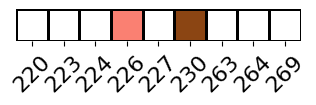

In [98]:
plt.figure(figsize=(3.3, 1.2))
EC50_df = pd.DataFrame.from_dict(EC50_dict, orient='index')
cmap = ['white','mediumaquamarine','saddlebrown','salmon']
sns.heatmap(EC50_df.loc[pocket_5_residues].T, cmap=cmap, square=True, linewidths=1, linecolor='k', cbar=False)
plt.xticks(rotation=45, fontsize=16)
plt.yticks([])

plt.tight_layout()
#plt.savefig('NAM_signaling_EC50_cats.png', dpi=250)